# Define similarity-measure functions

In [1]:
# define similarity-measure functions
library(proxy)
library(transport)
library(dtw)

# Kullback-Leibler divergence
KL <- function(s1,s2){
s1[ which(s1<0)] <- 0
s2[ which(s2 <0)] <- 0

s1 <- s1/sum(s1) 
s2 <- s2/sum(s2) 
id <- intersect(which(  (s1>0)), which(  (s2>0)))

sum(s1[id] * log (s1[id]/s2[id]))
}

# Jensen-Shannon divergence (JSD)
JS <- function(s1,s2){
sm <- (s1+s2)/2
KL(s1,sm) + KL(s2,sm)
}

# Earth Mover's Distance (EMD)
EMD <- function(s1,s2){
  s1 <- s1/sum(s1)
  s2 <- s2/sum(s2)
  costm <- outer(1:length(s1), 1:length(s2), FUN = function(x, y) abs(x - y))
  res <- transport(s1, s2, costm)
  sum(diag(costm[res$from, res$to]) * res$mass)
}

# target <- xas # dataset to calculate similarity
# ref <- 1 # reference data for similarity calculation
distance <- function(target,ref,nlen){
  # calculate distance matrix
  distm.e <- as.matrix(dist(target))
  distm.m <- as.matrix(dist(target,method = "manhattan"))
  distm.cos <- as.matrix(dist(target,method = "cosine"))
  distm.p <- cor(t(target),method = "pearson")
  dist.dtw <- dist.emd <- NULL

  for(i in 1:(nlen)){
    dist.dtw[i] <- dtw(target[i,],target[ref,])$distance
    dist.emd[i] <- EMD(target[i,],target[ref,])
  }

  # distance between data and the spectrum at 10Dq=0
  data.frame(
    e = distm.e[ref,],
    m = distm.m[ref,],
    cos = distm.cos[ref,],
    p = distm.p[ref,],
    js = apply(target,1,function(x) JS(target[ref,],x)),
    dtw = dist.dtw,
    emd = dist.emd
  )
}

similarity <- function(d,dmax){
  # convert distance to similarity
  data.frame(
    e = 1 - d$e/dmax$e,
    m = 1 - d$m/dmax$m,
    cos = 1 - d$cos/dmax$cos,
    p = 1 - (1-d$p)/(1-dmax$p),
    js = 1 - d$js/dmax$js,
    dtw = 1 - d$dtw/dmax$dtw,
    emd = 1 - d$emd/dmax$emd
  )
}

dmax <- function(d,nlen){
  data.frame(e = d$e[nlen],
    m = d$m[nlen],
    cos = d$cos[nlen],
    p = d$p[nlen],
    js = d$js[nlen],
    dtw = d$dtw[nlen],
    emd = d$emd[nlen]
  )
}


Attaching package: ‘proxy’

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loaded dtw v1.20-1. See ?dtw for help, citation("dtw") for use in publication.



In [2]:
# calculate the maximum of the distance for normalization.
xas <- read.csv("./Mn2_XAS_raw.csv",header=T, check.names=F)
pe <- xas$'PhotonEnergy (eV)'
specs <- xas[,-27]
dq <- as.numeric(colnames(specs))
specs <- t(specs)
nlen.xas <- length(dq)

target <- specs
ref <- 1 
dist.xas <- distance(target,ref,nlen.xas)
dmax.xas <- dmax(dist.xas,nlen.xas)

Initial solution based on shortlist is degenerate. Adding 587 basis vector(s)... done.
Initial solution based on shortlist is degenerate. Adding 48 basis vector(s)... done.
Initial solution based on shortlist is degenerate. Adding 18 basis vector(s)... done.
Initial solution based on shortlist is degenerate. Adding 6 basis vector(s)... done.
Initial solution based on shortlist is degenerate. Adding 2 basis vector(s)... done.
Initial solution based on shortlist is degenerate. Adding 1 basis vector(s)... done.
Initial solution based on shortlist is degenerate. Adding 1 basis vector(s)... done.


# Figure 3. Similarity as a function of 10Dq

Initial solution based on shortlist is degenerate. Adding 334 basis vector(s)... done.


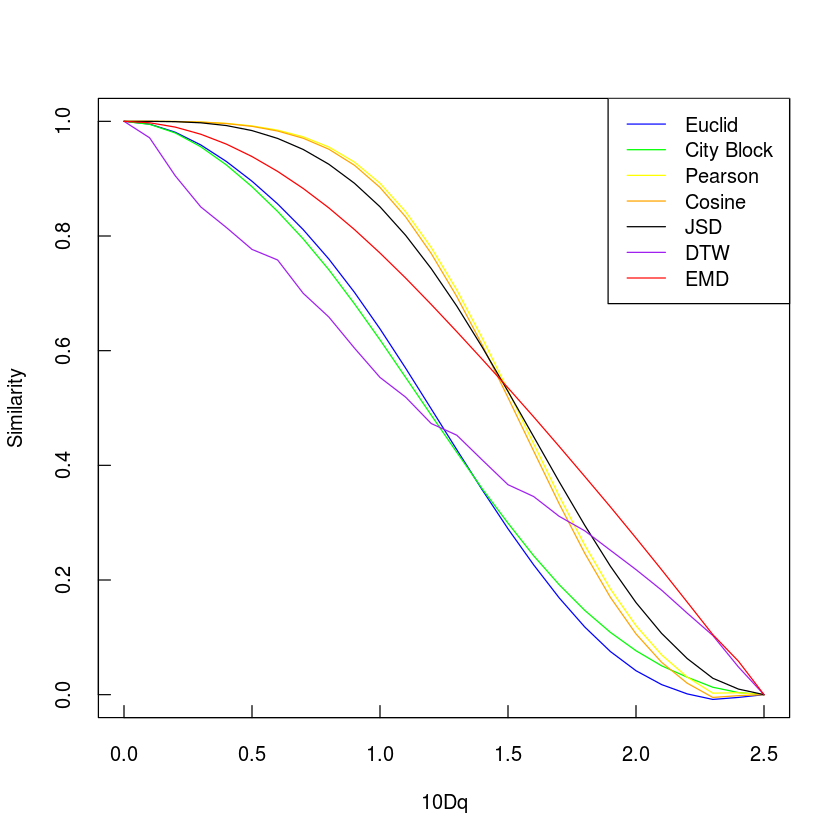

In [3]:
xas <- read.csv('Mn2_XAS.csv',header=TRUE, check.names=FALSE)
pe <- xas$'PhotonEnergy (eV)'
specs <- xas[,-27]
specs <- t(specs)
dq <- seq(0, 2.5, by=0.1)
nlen.xas <- length(dq)

target <- specs
ref <- 1 
dist.xas <- distance(target,ref,nlen.xas)
dmax.comp <- dmax(dist.xas,nlen.xas)
sim <- similarity(dist.xas, dmax.comp)
# write.csv(sim, "sim_10Dq.csv", quote=FALSE, row.names=TRUE)

# Plot symilarity vs 10Dq
plot(dq,sim$e,ylim=c(0,1),type="l",lwd=1,col="blue",xlab="10Dq",ylab="Similarity",tcl=0.5)
lines(dq,sim$m,type="l",lwd=1,ylim=c(0,1),col="green",ann="F")
lines(dq,sim$p,type="l",lwd=1,ylim=c(0,1),col="yellow",ann="F")
lines(dq,sim$cos,type="l",lwd=1,ylim=c(0,1),col="orange",ann="F")
lines(dq,sim$js,type="l",lwd=1,ylim=c(0,1),col="black",ann="F")
lines(dq,sim$dtw,type="l",lwd=1,ylim=c(0,1),col="purple",ann="F")
lines(dq,sim$emd,type="l",lwd=1,ylim=c(0,1),col="red",ann="F")
legend("topright", legend = c("Euclid","City Block","Pearson","Cosine","JSD","DTW","EMD"),
                   col = c("blue", "green", "yellow", "orange", "black", "purple", "red"),lty = 1)

In [4]:
xas_exp_calc <- read.csv('MnOexp.csv',header=TRUE)
xas_comparison <- data.frame(
    'Mn2Oh_calc' = specs[1,]/sum(specs[1,]),
    'MnO_exp' = xas_exp_calc$MnO_XAS
)

target <- t(xas_comparison)
ref <- 1
nlen.xas <- 2
dist.xas <- distance(target,ref,nlen.xas)
sim_exp <- similarity(dist.xas, dmax.comp)

Initial solution based on shortlist is degenerate. Adding 334 basis vector(s)... done.


Warning message in transport.default(s1, s2, costm):
“total mass in a and b differs. Normalizing a and b to probability measures.”

In [5]:
sim_exp

e,m,cos,p,js,dtw,emd
1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9999999
0.6262044,0.5667332,0.8900221,0.9052931,0.8059461,0.3380757,0.3628677


## build a regression model
fit the polynomial functions (up to ten-degrees) to the data, and choose the suitable model with Akaike Information Criterion.

Fixed term is "(Intercept)"



Call:
lm(formula = y ~ x.1 + x.10 + x.2 + x.4 + x.5 + x.6 + x.7 + x.8 + 
    x.9 + 1, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.181388 -0.026053  0.006308  0.030715  0.111764 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.420e+00  4.720e-02  51.261   <2e-16 ***
x.1         -8.956e+00  3.046e+00  -2.940   0.0096 ** 
x.10        -1.249e+04  6.213e+03  -2.010   0.0616 .  
x.2          6.734e+01  3.572e+01   1.885   0.0777 .  
x.4         -3.230e+03  1.896e+03  -1.703   0.1079    
x.5          2.073e+04  1.202e+04   1.725   0.1038    
x.6         -6.301e+04  3.565e+04  -1.767   0.0962 .  
x.7          1.079e+05  5.925e+04   1.821   0.0874 .  
x.8         -1.064e+05  5.657e+04  -1.880   0.0784 .  
x.9          5.643e+04  2.903e+04   1.944   0.0697 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07783 on 16 degrees of freedom
Multiple R-squared:  0.9934,	Adjusted R-sq

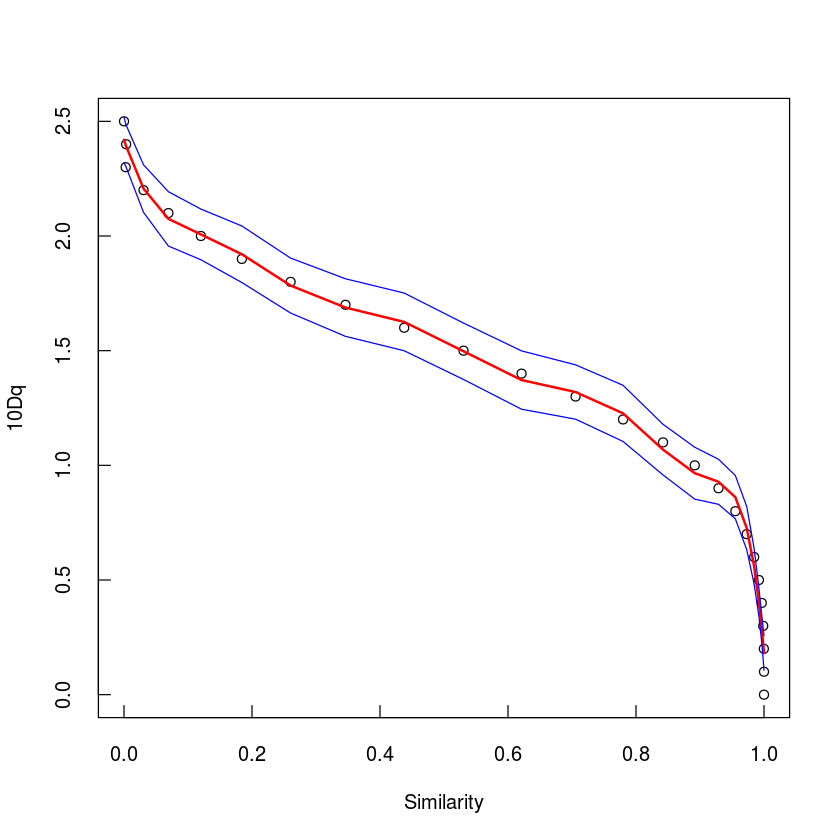

In [7]:
library(MuMIn)
options(na.action = "na.fail")

df <- data.frame(y = dq, 
                 x = poly(sim$p,10,raw=TRUE))

fullmodel <- lm(y~.,data=df)
ret <- dredge(fullmodel,rank="AIC")
best.model <- get.models(ret, subset = 1)[1][[1]]

pred <- predict(best.model,interval ="confidence",level = 0.95)
plot(x=sim$p,y=dq,xlab="Similarity",ylab="10Dq",tcl=0.5)
lines(x=sim$p,y=pred[,1], col="red", lwd=2)
lines(x=sim$p,y=pred[,2], col="blue")
lines(x=sim$p,y=pred[,3], col="blue")

summary(best.model)

# Figure 5.Similarity as a function of with Gaussian noise.

Initial solution based on shortlist is degenerate. Adding 598 basis vector(s)... done.


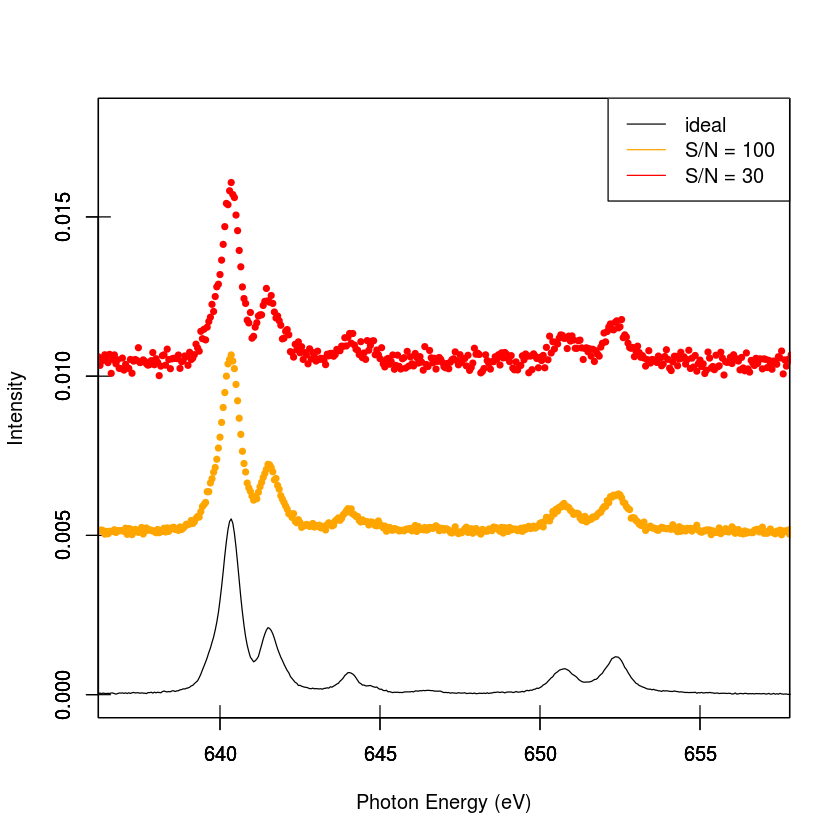

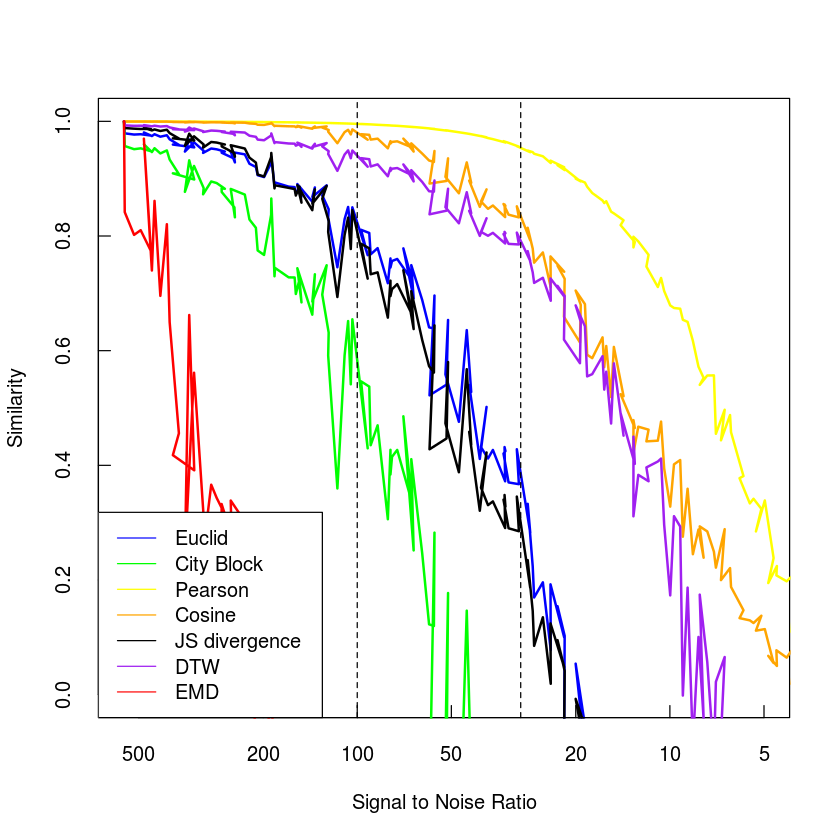

In [8]:
xas.noise <- read.csv("./xas_noise_snr.csv", header=TRUE, check.names=FALSE)
snr <- xas.noise$'snr'
specs.noise <- xas.noise[, -602]

target <- specs.noise
ref <- 1
nlen.noise <- dim(specs.noise)[1]
dist.noise <- distance(target,ref,nlen.noise)
sim <- similarity(dist.noise, dmax.xas)
pe <- seq(630, 660, length.out = 601)

plot(pe,specs.noise[1,], xlim=c(637,657), ylim=c(0, 1.8*10^-2), type="l", 
     xlab="Photon Energy (eV)", ylab="Intensity",tcl=0.5)
par(new=T);plot(pe, specs.noise[54,]+5*10^-3, xlim=c(637,657), ylim=c(0, 1.8*10^-2), pch=20, ann="F", col="orange")
par(new=T);plot(pe, specs.noise[92,]+10*10^-3, xlim=c(637,657), ylim=c(0, 1.8*10^-2), pch=20, ann="F", col="red")
legend("topright", legend = c("ideal", "S/N = 100", "S/N = 30"),col = c("black", "orange", "red"),lty = 1)

# Plot similarity as a function of SNR
plot(snr,sim$e,xlim=c(max(snr), 5),ylim=c(0,1),type="l",lwd=2,col="blue",
     xlab="Signal to Noise Ratio",ylab="Similarity",log="x",tcl=0.5)
lines(snr,sim$m,type="l",xlim=c(max(snr), 5),lwd=2,ylim=c(0,1),col="green",ann="F")
lines(snr,sim$p,type="l",xlim=c(max(snr), 5),lwd=2,ylim=c(0,1),col="yellow",ann="F")
lines(snr,sim$cos,type="l",xlim=c(max(snr), 5),lwd=2,ylim=c(0,1),col="orange",ann="F")
lines(snr,sim$js,type="l",xlim=c(max(snr), 5),lwd=2,ylim=c(0,1),col="black",ann="F")
lines(snr,sim$dtw,type="l",xlim=c(max(snr), 5),lwd=2,ylim=c(0,1),col="purple",ann="F")
lines(snr,sim$emd,type="l",xlim=c(max(snr), 5),lwd=2,ylim=c(0,1),col="red",ann="F")
abline(v=30,lty=2);abline(v=100,lty=2)
legend("bottomleft", legend = c("Euclid","City Block","Pearson","Cosine","JS divergence","DTW","EMD"),
                   col = c("blue", "green", "yellow", "orange", "black", "purple", "red"),lty = 1)

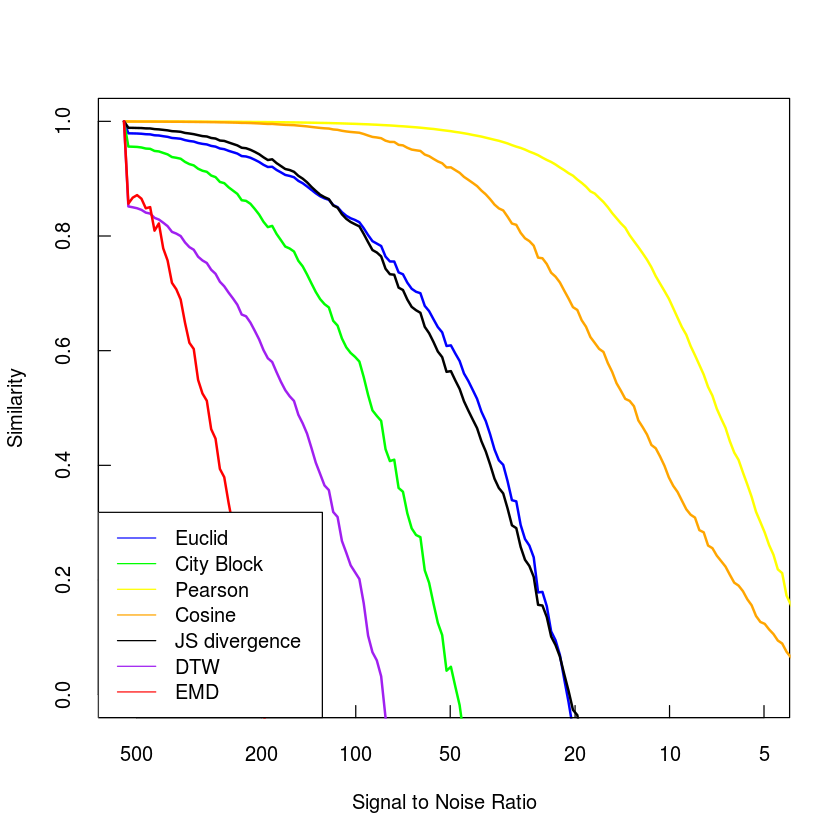

In [9]:
# plot the 100times averaged result.
load(file = 'sim_gaussnoise_100avg.Rdata')
load(file = 'snr_gaussnoise_100avg.Rdata')

# Plot similarity as a function of SNR
plot(snr,sim$e,xlim=c(max(snr),5),ylim=c(0,1),type="l",lwd=2,col="blue",
     xlab="Signal to Noise Ratio",ylab="Similarity",log="x",tcl=0.5)
lines(snr,sim$m,type="l",xlim=c(max(snr),5),lwd=2,ylim=c(0,1),col="green",ann="F")
lines(snr,sim$p,type="l",xlim=c(max(snr),5),lwd=2,ylim=c(0,1),col="yellow",ann="F")
lines(snr,sim$cos,type="l",xlim=c(max(snr),5),lwd=2,ylim=c(0,1),col="orange",ann="F")
lines(snr,sim$js,type="l",xlim=c(max(snr),5),lwd=2,ylim=c(0,1),col="black",ann="F")
lines(snr,sim$dtw,type="l",xlim=c(max(snr),5),lwd=2,ylim=c(0,1),col="purple",ann="F")
lines(snr,sim$emd,type="l",xlim=c(max(snr),5),lwd=2,ylim=c(0,1),col="red",ann="F")
legend("bottomleft", legend = c("Euclid","City Block","Pearson","Cosine","JS divergence","DTW","EMD"),
                   col = c("blue", "green", "yellow", "orange", "black", "purple", "red"),lty = 1)
# write.csv(sim, "sim_snr.csv", quote=FALSE, row.names=TRUE)
# write.csv(snr, "snr.csv", quote=FALSE, row.names=TRUE)

# Figure 6.Similarity as a function of $\sigma$.

Initial solution based on shortlist is degenerate. Adding 600 basis vector(s)... done.
Initial solution based on shortlist is degenerate. Adding 15 basis vector(s)... done.
Initial solution based on shortlist is degenerate. Adding 1 basis vector(s)... done.
Initial solution based on shortlist is degenerate. Adding 1 basis vector(s)... done.


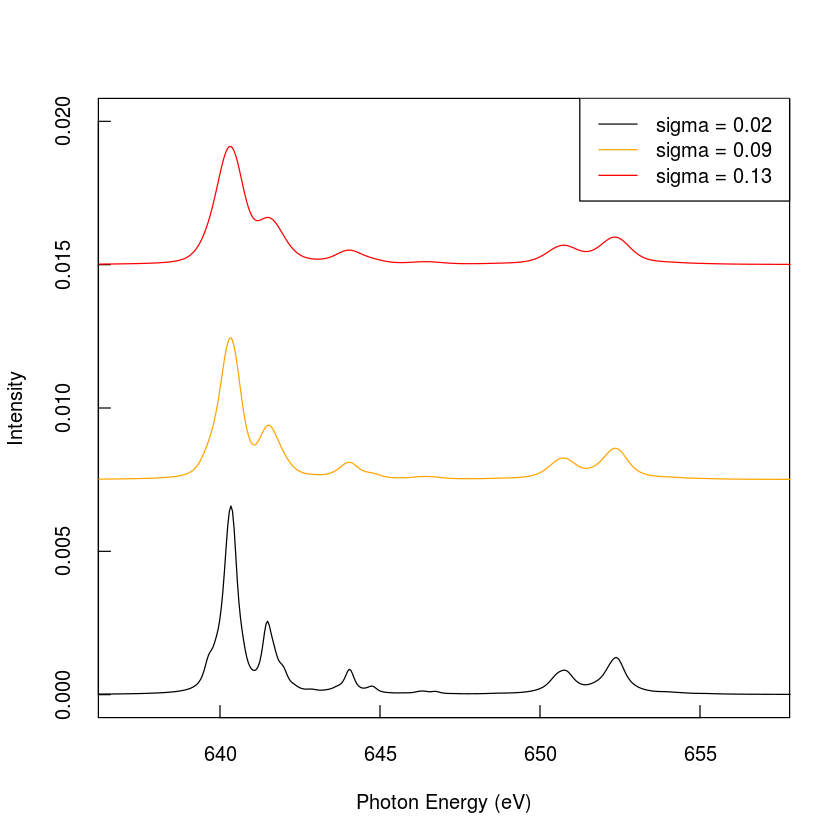

In [10]:
xas.broad <- read.csv("./Mn2_00_broading.csv", header=TRUE, check.names=FALSE)
pe <- xas.broad$'PhotonEnergy (eV)'
broad <- as.numeric(colnames(xas.broad[,-11]))
sigma.gauss = broad/(2*(sqrt(2*log(2))))
specs.broad <- t(xas.broad[,-11])

target <- specs.broad
ref <- 1
nlen.broad <- dim(specs.broad)[1]
dist.broad <- distance(target,ref,nlen.broad)
sim <- similarity(dist.broad, dmax.xas)
# write.csv(sim, "sim_broad.csv", quote=FALSE, row.names=TRUE)

plot(pe,specs.broad[1,],xlim=c(637,657),ylim=c(0,0.02),type="l",
     xlab="Photon Energy (eV)",ylab="Intensity",tcl=0.5)
lines(pe,specs.broad[4,]+0.0075,xlim=c(637,657),ylim=c(0,0.02),type="l",ann="F", col="orange")
lines(pe,specs.broad[6,]+0.015,xlim=c(637,657),ylim=c(0,0.02),type="l",ann="F", col="red")
legend("topright", legend = c("sigma = 0.02", "sigma = 0.09", "sigma = 0.13"),col = c("black", "orange", "red"),lty = 1)
graphics.off()

# Plot similarity as a function of sigma
plot(sigma.gauss,sim$e,ylim=c(0,1),type="l",lwd=2,col="blue",
     xlab="sigma of Gauss dist.(eV)",ylab="Similarity",tcl=0.5)
lines(sigma.gauss,sim$m,type="l",lwd=2,ylim=c(0,1),col="green",ann="F")
lines(sigma.gauss,sim$p,type="l",lwd=2,ylim=c(0,1),col="yellow",ann="F")
lines(sigma.gauss,sim$cos,type="l",lwd=2,ylim=c(0,1),col="orange",ann="F")
lines(sigma.gauss,sim$js,type="l",lwd=2,ylim=c(0,1),col="black",ann="F")
lines(sigma.gauss,sim$dtw,type="l",lwd=2,ylim=c(0,1),col="purple",ann="F")
lines(sigma.gauss,sim$emd,type="l",lwd=2,ylim=c(0,1),col="red",ann="F")
legend("bottomleft", legend = c("Euclid","City Block","Pearson","Cosine","JS divergence","DTW","EMD"),
                   col = c("blue", "green", "yellow", "orange", "black", "purple", "red"),lty = 1)
abline(v=sigma.gauss[4],lty=2);abline(v=sigma.gauss[6],lty=2)

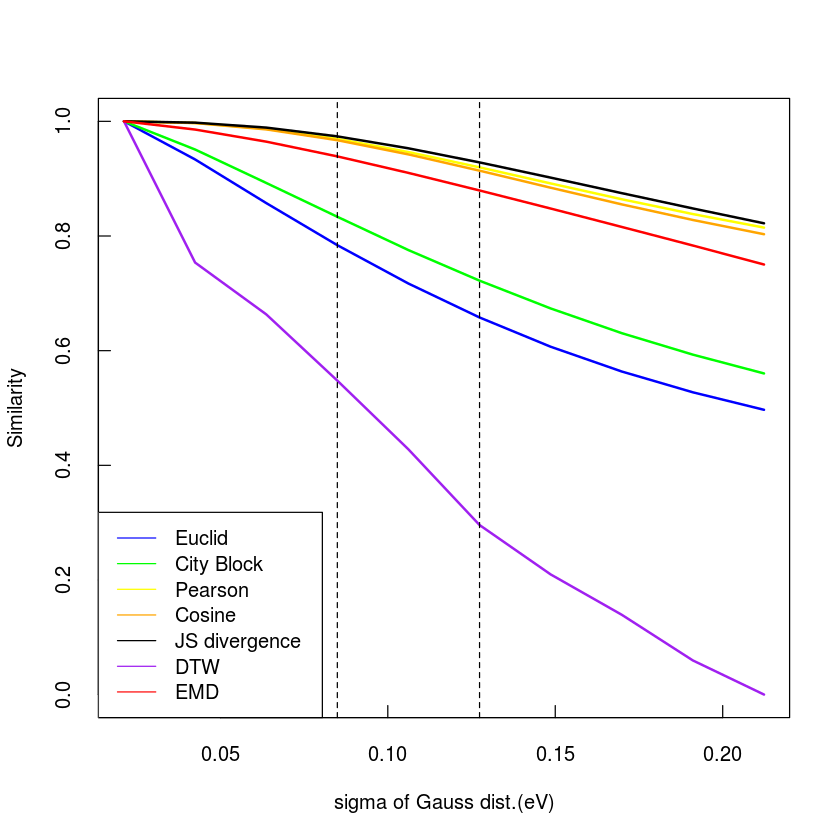

In [11]:
plot(sigma.gauss,sim$e,ylim=c(0,1),type="l",lwd=2,col="blue",
     xlab="sigma of Gauss dist.(eV)",ylab="Similarity",tcl=0.5)
lines(sigma.gauss,sim$m,type="l",lwd=2,ylim=c(0,1),col="green",ann="F")
lines(sigma.gauss,sim$p,type="l",lwd=2,ylim=c(0,1),col="yellow",ann="F")
lines(sigma.gauss,sim$cos,type="l",lwd=2,ylim=c(0,1),col="orange",ann="F")
lines(sigma.gauss,sim$js,type="l",lwd=2,ylim=c(0,1),col="black",ann="F")
lines(sigma.gauss,sim$dtw,type="l",lwd=2,ylim=c(0,1),col="purple",ann="F")
lines(sigma.gauss,sim$emd,type="l",lwd=2,ylim=c(0,1),col="red",ann="F")
abline(v=sigma.gauss[4],lty=2);abline(v=sigma.gauss[6],lty=2)
legend("bottomleft", legend = c("Euclid","City Block","Pearson","Cosine","JS divergence","DTW","EMD"),
                   col = c("blue", "green", "yellow", "orange", "black", "purple", "red"),lty = 1)